In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

In [4]:
# Set paths to your dataset folders
train_dir = '/content/drive/MyDrive/facial_expression_dataset/train'
val_dir = '/content/drive/MyDrive/facial_expression_dataset/validation'
test_dir = '/content/drive/MyDrive/facial_expression_dataset/test'

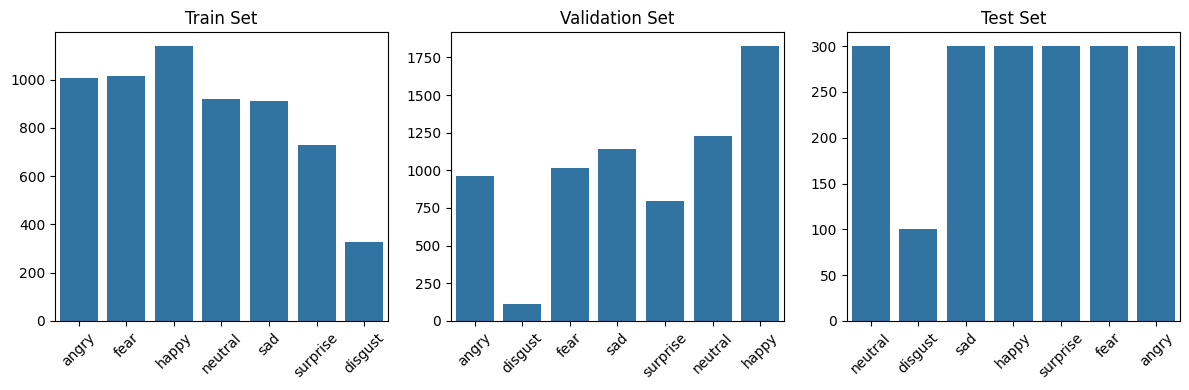

Train counts: {'angry': 1008, 'fear': 1016, 'happy': 1139, 'neutral': 921, 'sad': 913, 'surprise': 729, 'disgust': 329}
Validation counts: {'angry': 960, 'disgust': 111, 'fear': 1018, 'sad': 1139, 'surprise': 797, 'neutral': 1226, 'happy': 1825}
Test counts: {'neutral': 300, 'disgust': 100, 'sad': 300, 'happy': 300, 'surprise': 300, 'fear': 300, 'angry': 300}


In [8]:
# 1. Check Class Distribution
def count_images(directory):
    counts = {}
    for emotion in os.listdir(directory):
        emotion_dir = os.path.join(directory, emotion)
        if os.path.isdir(emotion_dir):
            counts[emotion] = len(os.listdir(emotion_dir))
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Plot class distribution
emotion_labels = sorted(train_counts.keys())
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Train Set')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()))
plt.title('Validation Set')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()))
plt.title('Test Set')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print exact counts
print("Train counts:", train_counts)
print("Validation counts:", val_counts)
print("Test counts:", test_counts)

In [11]:
# Get class names from the train directory (assuming all sets have same classes)
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

print(f"\nNumber of classes: {num_classes}")
print(f"Class names: {classes}")


Number of classes: 7
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [12]:
import cv2

# Pick a sample image from the dataset
sample_img_path = os.path.join(train_dir, classes[0], os.listdir(os.path.join(train_dir, classes[0]))[0])
sample_img = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale

height, width = sample_img.shape
print(f"\nImage resolution: {width}x{height} (Width x Height)")


Image resolution: 48x48 (Width x Height)


<ipython-input-13-18a987b49d57>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=emotions, y=counts, palette=palette)


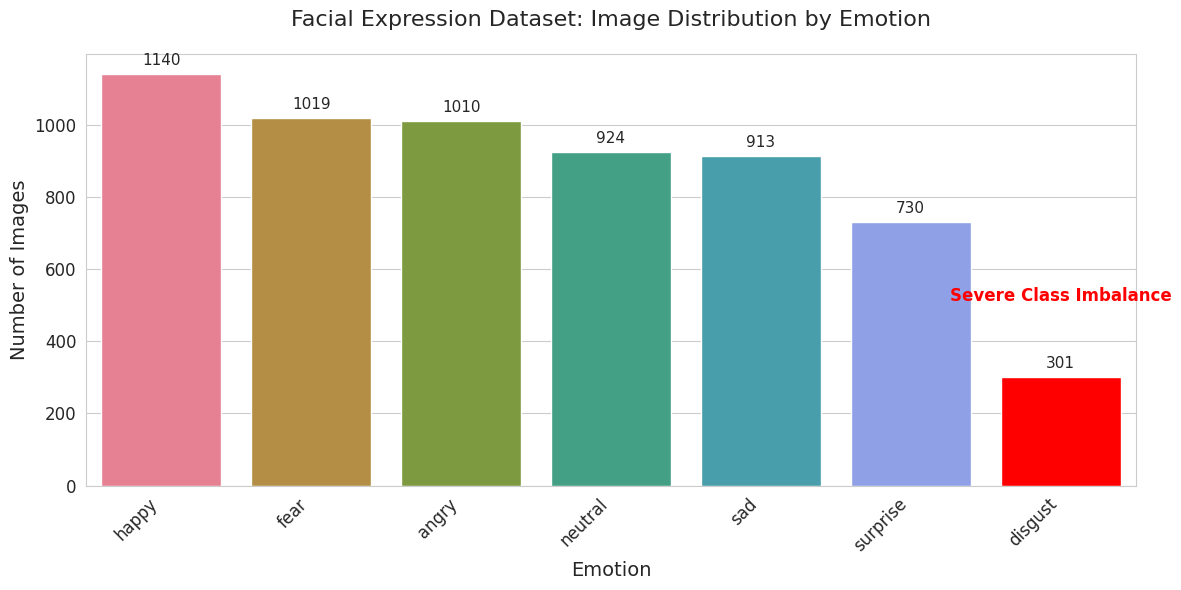

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
emotion_counts = {
    'angry': 1010,
    'disgust': 301,
    'fear': 1019,
    'happy': 1140,
    'surprise': 730,
    'sad': 913,
    'neutral': 924
}

# Sort by count (descending)
sorted_emotions = sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True)
emotions = [x[0] for x in sorted_emotions]
counts = [x[1] for x in sorted_emotions]

# Plot styling
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
palette = sns.color_palette("husl", len(emotions))  # Colorful palette

# Bar plot
ax = sns.barplot(x=emotions, y=counts, palette=palette)

# Customize plot
plt.title("Facial Expression Dataset: Image Distribution by Emotion", fontsize=16, pad=20)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on bars
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=11
    )

# Highlight the minority class (disgust)
ax.patches[emotions.index('disgust')].set_facecolor('red')  # Make disgust stand out
plt.text(
    emotions.index('disgust'), counts[emotions.index('disgust')] + 200,
    "Severe Class Imbalance",
    ha='center', va='bottom', color='red', fontsize=12, weight='bold'
)

plt.tight_layout()
plt.show()

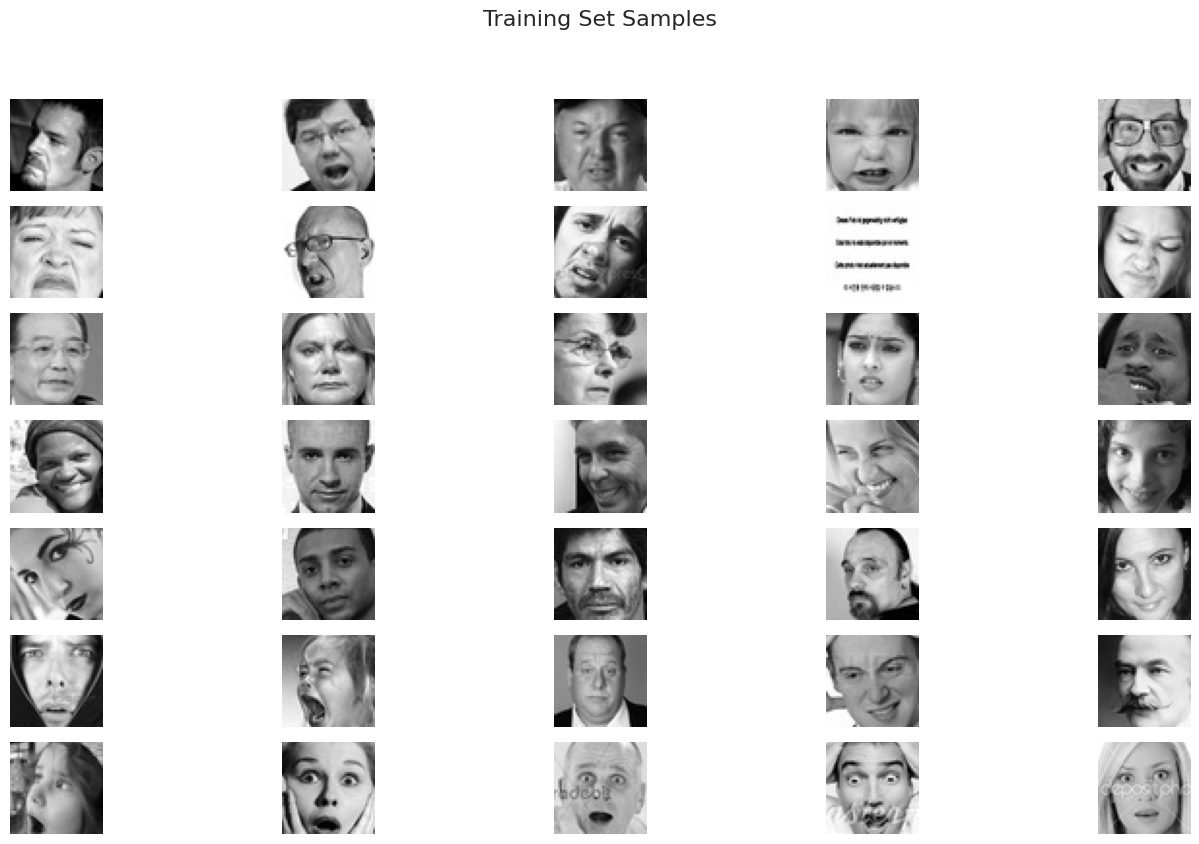

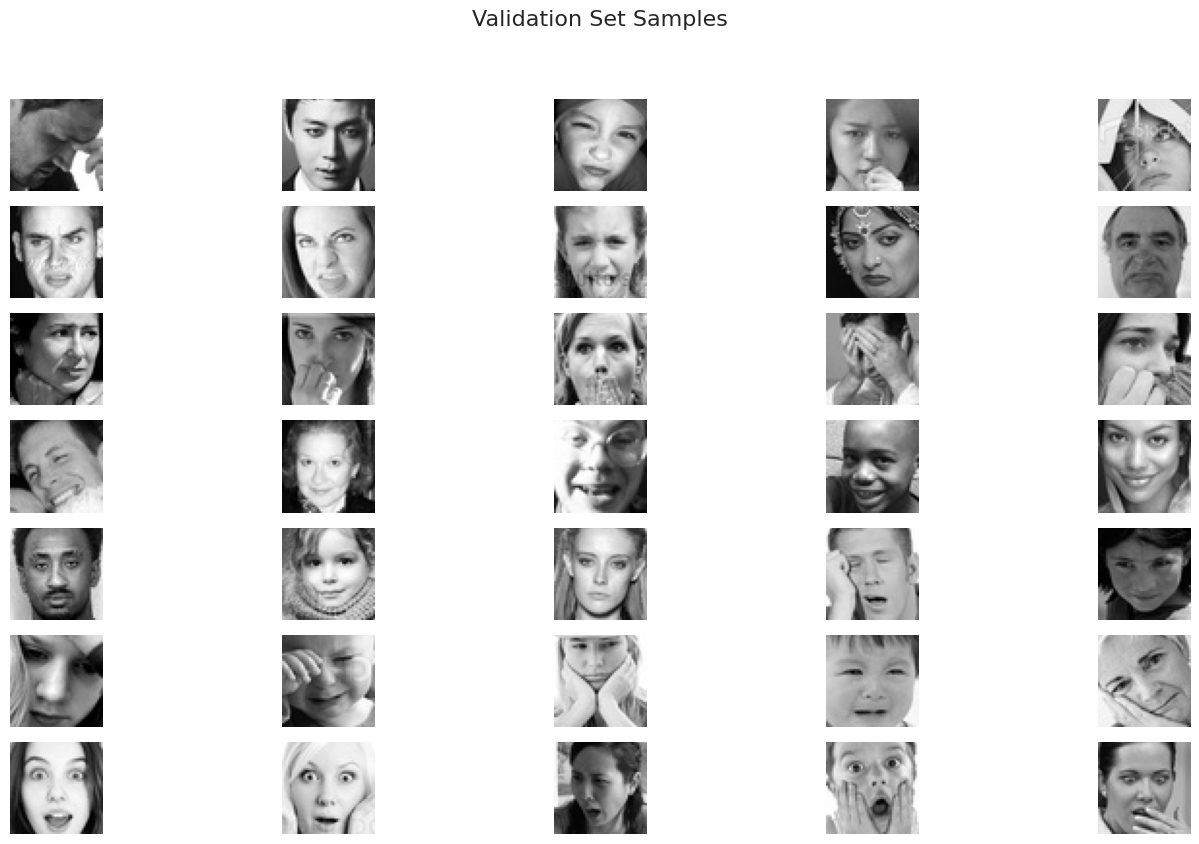

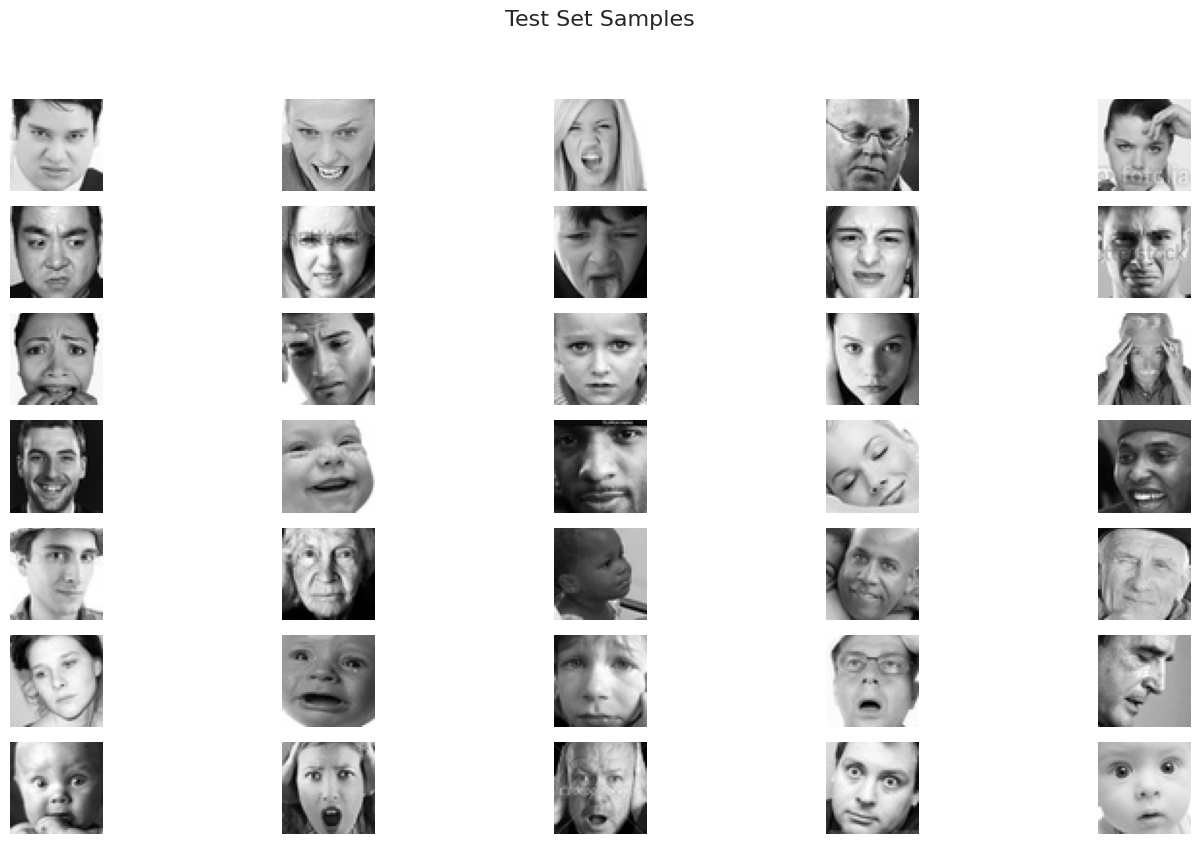

In [15]:
import os
import random
import matplotlib.pyplot as plt
import cv2

def plot_samples(directory, title, num_samples=5):
    emotions = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    plt.figure(figsize=(15, 8))
    plt.suptitle(title, fontsize=16, y=1.05)

    for i, emotion in enumerate(emotions):
        emotion_dir = os.path.join(directory, emotion)
        images = os.listdir(emotion_dir)
        sampled_images = random.sample(images, min(num_samples, len(images)))

        for j, img_name in enumerate(sampled_images):
            img_path = os.path.join(emotion_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            plt.subplot(len(emotions), num_samples, i * num_samples + j + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.ylabel(emotion, fontsize=12, rotation=0, ha='right', va='center')

    plt.tight_layout()
    plt.show()


plot_samples(train_dir, "Training Set Samples")
plot_samples(val_dir, "Validation Set Samples")
plot_samples(test_dir, "Test Set Samples")


In [16]:
# Continue from your existing imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **DATA AUGMENTATION**

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np
from tqdm import tqdm

# ========== STEP 1: Balance the dataset using saved augmentations ==========

# Path to your training images
train_dir = '/content/drive/MyDrive/facial_expression_dataset/train'

# Count number of images in each emotion folder
def count_images(directory):
    counts = {}
    for emotion in os.listdir(directory):
        emotion_path = os.path.join(directory, emotion)
        if os.path.isdir(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
    return counts

# Get counts per class and determine the max
class_counts = count_images(train_dir)
max_count = max(class_counts.values())

print("Original class counts:", class_counts)
print("Target per class:", max_count)

# Define your augmentation strategy
augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment images for underrepresented classes and save them
for emotion, count in class_counts.items():
    if count >= max_count:
        continue  # This class is already full

    emotion_path = os.path.join(train_dir, emotion)
    images = os.listdir(emotion_path)
    needed = max_count - count
    print(f"\n🔄 Augmenting '{emotion}': Need {needed} more images")

    i = 0
    pbar = tqdm(total=needed)
    while i < needed:
        img_name = np.random.choice(images)
        img_path = os.path.join(emotion_path, img_name)
        try:
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in augmentor.flow(x, batch_size=1, save_to_dir=emotion_path,
                                        save_prefix='aug', save_format='jpg'):
                i += 1
                pbar.update(1)
                if i >= needed:
                    break
        except Exception as e:
            print(f"Skipping error in {img_path}: {e}")
    pbar.close()

# Show updated counts
updated_counts = count_images(train_dir)
print("\n Updated class counts:")
for k, v in updated_counts.items():
    print(f"{k}: {v}")

# ========== STEP 2: Create real-time data generators for training ==========

# Image dimensions and batch size
img_size = (48, 48)
batch_size = 64

# Real-time augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescale only (no augmentation) for validation and test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Directories (replace these with your actual paths)
val_dir = '/content/drive/MyDrive/facial_expression_dataset/validation'
test_dir = '/content/drive/MyDrive/facial_expression_dataset/test'

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Original class counts: {'angry': 1008, 'fear': 1016, 'happy': 1139, 'neutral': 921, 'sad': 913, 'surprise': 729, 'disgust': 329}
Target per class: 1139

🔄 Augmenting 'angry': Need 131 more images


100%|██████████| 131/131 [00:01<00:00, 88.57it/s]



🔄 Augmenting 'fear': Need 123 more images


100%|██████████| 123/123 [00:01<00:00, 85.96it/s]



🔄 Augmenting 'neutral': Need 218 more images


100%|██████████| 218/218 [00:02<00:00, 80.26it/s]



🔄 Augmenting 'sad': Need 226 more images


100%|██████████| 226/226 [00:03<00:00, 74.70it/s]



🔄 Augmenting 'surprise': Need 410 more images


100%|██████████| 410/410 [00:05<00:00, 74.50it/s]



🔄 Augmenting 'disgust': Need 810 more images


100%|██████████| 810/810 [00:09<00:00, 83.13it/s]



 Updated class counts:
angry: 1138
fear: 1139
happy: 1139
neutral: 1135
sad: 1135
surprise: 1132
disgust: 1109
Found 7927 images belonging to 7 classes.
Found 7076 images belonging to 7 classes.
Found 1900 images belonging to 7 classes.


Showing augmented samples from: angry


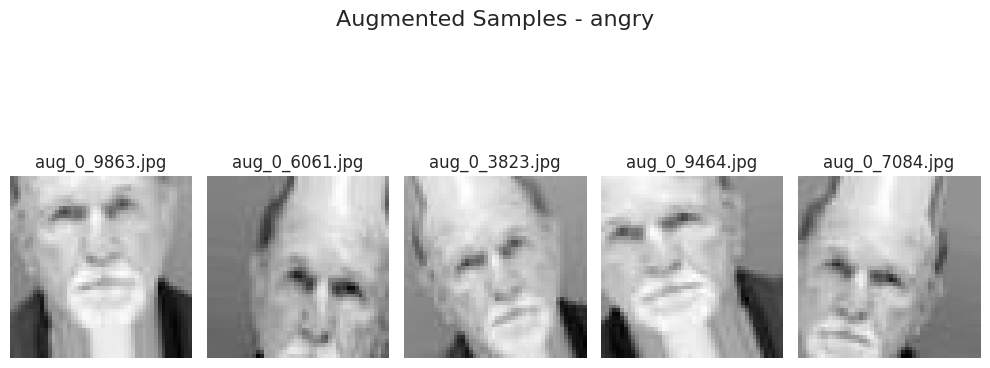

Showing augmented samples from: fear


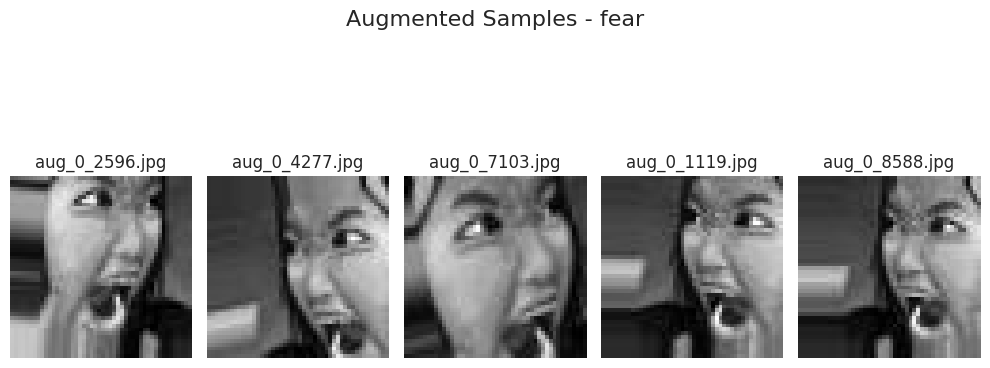

No augmented images found in 'happy'
Showing augmented samples from: neutral


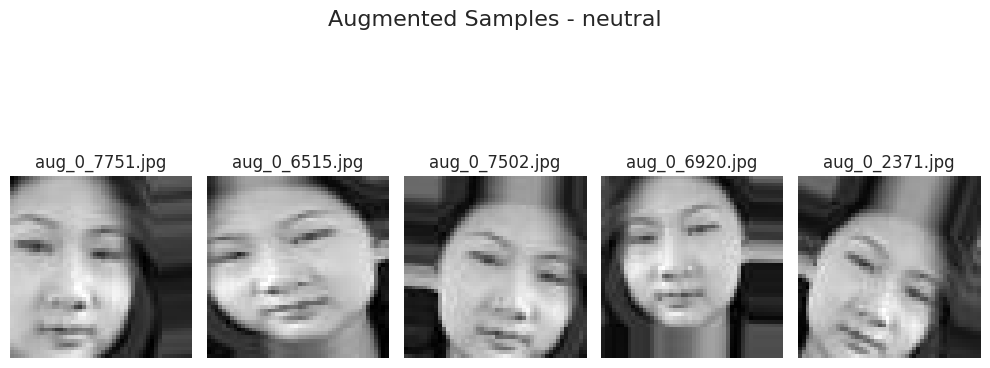

Showing augmented samples from: sad


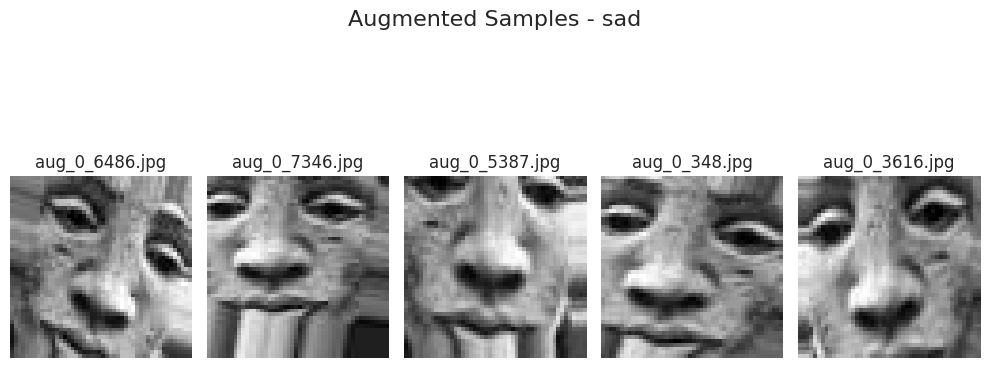

Showing augmented samples from: surprise


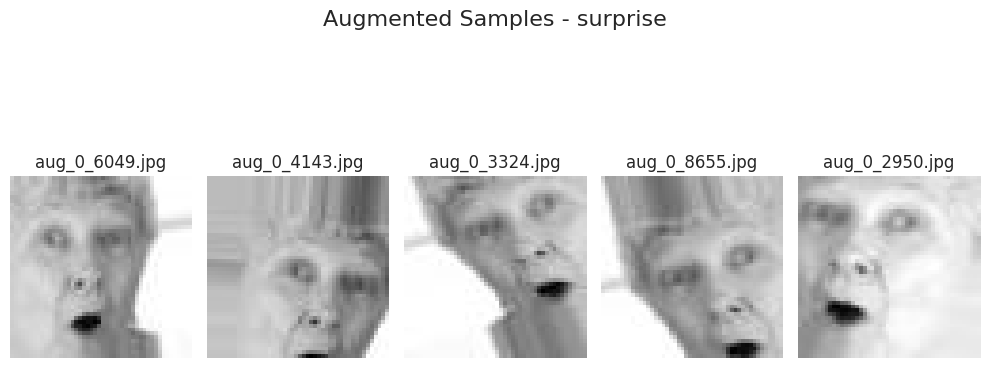

Showing augmented samples from: disgust


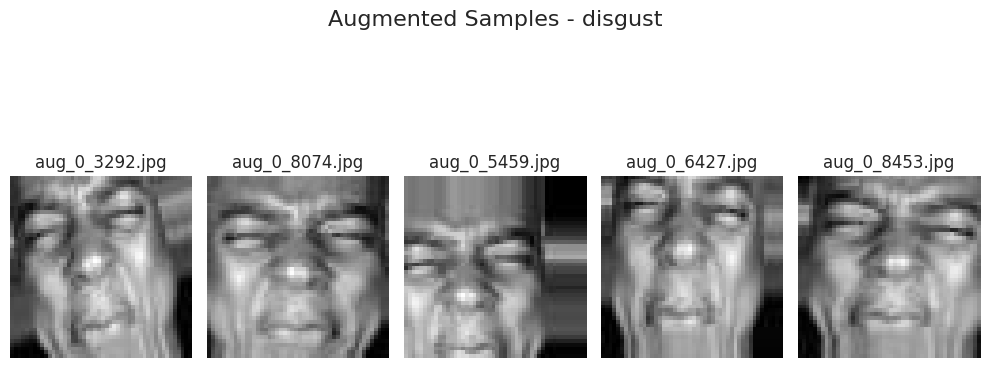

In [20]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import os

# Loop through all emotion folders
for emotion_folder in os.listdir(train_dir):
    emotion_path = os.path.join(train_dir, emotion_folder)

    if not os.path.isdir(emotion_path):
        continue

    # Filter only augmented images (starting with 'aug_')
    augmented_images = [img for img in os.listdir(emotion_path) if img.startswith('aug_')]

    if len(augmented_images) == 0:
        print(f"No augmented images found in '{emotion_folder}'")
        continue

    print(f"Showing augmented samples from: {emotion_folder}")

    # Display 5 augmented images
    plt.figure(figsize=(10, 5))
    for i in range(5):
        img_name = random.choice(augmented_images)
        img_path = os.path.join(emotion_path, img_name)
        img = Image.open(img_path)

        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_name)

    plt.suptitle(f"Augmented Samples - {emotion_folder}", fontsize=16)
    plt.tight_layout()
    plt.show()


## **3.1.2 Design, Train, and Evaluate a Baseline Model**

1. Model Architecture: [2]:
• Build a baseline CNN model with the following structure:
– Three Convolutional layers, each followed by pooling layers.
– Three fully connected layers (FCN)
– An output layer suitable for classification.
• Use an appropriate activation function and kernel size for each layer.
• Print and analyze the model summary.

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_classes = 7  # example, change to your number of classes
input_shape = (48, 48, 1)  # grayscale images resized to 48x48

def build_baseline_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),

        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),

        Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

baseline_model = build_baseline_model()
baseline_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,823 (2.51 MB)

 Trainable params: 658,823 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

2. Model Training

Removing corrupted image

In [22]:
import os
from PIL import Image, UnidentifiedImageError

def clean_dataset(root_dir):
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify image integrity
            except (UnidentifiedImageError, OSError):
                print(f"Deleting bad file: {file_path}")
                os.remove(file_path)

# Run this on your datasets
clean_dataset(train_dir)
clean_dataset(val_dir)
clean_dataset(test_dir)


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Enhanced Data Generators with Augmentation (only for training)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       # Reduced from 20° for 48x48 images
    width_shift_range=0.1,   # Reduced from 0.2
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test generators (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators with balanced class weights
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/facial_expression_dataset/train',
    target_size=(48, 48),
    batch_size=32,  # Reduced from 64 for better gradient estimates
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/facial_expression_dataset/validation',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/facial_expression_dataset/test',
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 7927 images belonging to 7 classes.
Found 7076 images belonging to 7 classes.
Found 1900 images belonging to 7 classes.


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import time

# Calculate class weights
train_classes = train_generator.classes
class_weights = compute_class_weight('balanced',
                                   classes=np.unique(train_classes),
                                   y=train_classes)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)

# Model compilation with adjusted learning rate
baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Training with callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

start_time = time.time()
baseline_history = baseline_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict  # Now properly defined
)
baseline_time = (time.time() - start_time)/60

print(f"\nTraining completed in {baseline_time:.2f} minutes")
print(f"Stopped early at epoch {len(baseline_history.history['loss'])}")

Class weights: {0: np.float64(0.9951041928194828), 1: np.float64(1.0211258534071879), 2: np.float64(0.9942305280321083), 3: np.float64(0.9942305280321083), 4: np.float64(0.9977344241661422), 5: np.float64(0.9977344241661422), 6: np.float64(1.0003785966683494)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.1852 - loss: 1.9167 - precision: 0.3457 - recall: 0.0039

248/248 ━━━━━━━━━━━━━━━━━━━━ 105s 376ms/step - accuracy: 0.1854 - loss: 1.9165 - precision: 0.3472 - recall: 0.0040 - val_accuracy: 0.2162 - val_loss: 1.8461 - val_precision: 0.3261 - val_recall: 0.0171
Epoch 2/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3315 - loss: 1.6816 - precision: 0.7664 - recall: 0.1085

248/248 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - accuracy: 0.3316 - loss: 1.6814 - precision: 0.7665 - recall: 0.1086 - val_accuracy: 0.2458 - val_loss: 1.7456 - val_precision: 0.5842 - val_recall: 0.0157
Epoch 3/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.3874 - loss: 1.5680 - precision: 0.8565 - recall: 0.1493

248/248 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - accuracy: 0.3874 - loss: 1.5680 - precision: 0.8564 - recall: 0.1493 - val_accuracy: 0.2825 - val_loss: 1.7380 - val_precision: 0.6048 - val_recall: 0.0355
Epoch 4/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.4192 - loss: 1.4871 - precision: 0.8487 - recall: 0.1887

248/248 ━━━━━━━━━━━━━━━━━━━━ 140s 327ms/step - accuracy: 0.4192 - loss: 1.4871 - precision: 0.8487 - recall: 0.1888 - val_accuracy: 0.3177 - val_loss: 1.6715 - val_precision: 0.6008 - val_recall: 0.0442
Epoch 5/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 331ms/step - accuracy: 0.4427 - loss: 1.4171 - precision: 0.8747 - recall: 0.2198 - val_accuracy: 0.3445 - val_loss: 1.6838 - val_precision: 0.5733 - val_recall: 0.0608
Epoch 6/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.4739 - loss: 1.3704 - precision: 0.8650 - recall: 0.2485

248/248 ━━━━━━━━━━━━━━━━━━━━ 93s 374ms/step - accuracy: 0.4739 - loss: 1.3704 - precision: 0.8650 - recall: 0.2485 - val_accuracy: 0.3848 - val_loss: 1.6085 - val_precision: 0.6583 - val_recall: 0.0958
Epoch 7/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4714 - loss: 1.3272 - precision: 0.8673 - recall: 0.2679

248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 329ms/step - accuracy: 0.4715 - loss: 1.3272 - precision: 0.8673 - recall: 0.2679 - val_accuracy: 0.3868 - val_loss: 1.5909 - val_precision: 0.6369 - val_recall: 0.1167
Epoch 8/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5059 - loss: 1.2923 - precision: 0.8376 - recall: 0.2902

248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 328ms/step - accuracy: 0.5059 - loss: 1.2922 - precision: 0.8376 - recall: 0.2903 - val_accuracy: 0.4121 - val_loss: 1.5507 - val_precision: 0.6673 - val_recall: 0.1499
Epoch 9/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5258 - loss: 1.2391 - precision: 0.8628 - recall: 0.3233

248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 325ms/step - accuracy: 0.5258 - loss: 1.2391 - precision: 0.8627 - recall: 0.3233 - val_accuracy: 0.4267 - val_loss: 1.4958 - val_precision: 0.6929 - val_recall: 0.1929
Epoch 10/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5281 - loss: 1.2535 - precision: 0.8377 - recall: 0.3067

248/248 ━━━━━━━━━━━━━━━━━━━━ 79s 320ms/step - accuracy: 0.5281 - loss: 1.2534 - precision: 0.8378 - recall: 0.3068 - val_accuracy: 0.4405 - val_loss: 1.4817 - val_precision: 0.7495 - val_recall: 0.1577
Epoch 11/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5313 - loss: 1.2025 - precision: 0.8570 - recall: 0.3378

248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.5313 - loss: 1.2025 - precision: 0.8570 - recall: 0.3378 - val_accuracy: 0.4577 - val_loss: 1.4159 - val_precision: 0.7014 - val_recall: 0.2267
Epoch 12/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 327ms/step - accuracy: 0.5470 - loss: 1.1784 - precision: 0.8374 - recall: 0.3552 - val_accuracy: 0.4512 - val_loss: 1.4283 - val_precision: 0.6923 - val_recall: 0.2452
Epoch 13/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5516 - loss: 1.1487 - precision: 0.8561 - recall: 0.3619

248/248 ━━━━━━━━━━━━━━━━━━━━ 92s 372ms/step - accuracy: 0.5516 - loss: 1.1487 - precision: 0.8560 - recall: 0.3619 - val_accuracy: 0.4624 - val_loss: 1.4023 - val_precision: 0.7314 - val_recall: 0.2231
Epoch 14/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 130s 322ms/step - accuracy: 0.5633 - loss: 1.1401 - precision: 0.8460 - recall: 0.3644 - val_accuracy: 0.4623 - val_loss: 1.4251 - val_precision: 0.6989 - val_recall: 0.2523
Epoch 15/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5778 - loss: 1.1230 - precision: 0.8346 - recall: 0.3750

248/248 ━━━━━━━━━━━━━━━━━━━━ 93s 375ms/step - accuracy: 0.5778 - loss: 1.1229 - precision: 0.8346 - recall: 0.3750 - val_accuracy: 0.4809 - val_loss: 1.3797 - val_precision: 0.6775 - val_recall: 0.3040
Epoch 16/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5644 - loss: 1.1305 - precision: 0.8342 - recall: 0.3774

248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 328ms/step - accuracy: 0.5644 - loss: 1.1305 - precision: 0.8343 - recall: 0.3775 - val_accuracy: 0.4962 - val_loss: 1.3113 - val_precision: 0.7132 - val_recall: 0.2995
Epoch 17/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 79s 315ms/step - accuracy: 0.5839 - loss: 1.0807 - precision: 0.8387 - recall: 0.3966 - val_accuracy: 0.4833 - val_loss: 1.3467 - val_precision: 0.7230 - val_recall: 0.2435
Epoch 18/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 80s 323ms/step - accuracy: 0.5924 - loss: 1.0758 - precision: 0.8437 - recall: 0.4040 - val_accuracy: 0.4960 - val_loss: 1.3228 - val_precision: 0.7035 - val_recall: 0.3125
Epoch 19/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 81s 326ms/step - accuracy: 0.5889 - loss: 1.0706 - precision: 0.8384 - recall: 0.4069 - val_accuracy: 0.4760 - val_loss: 1.4155 - val_precision: 0.6392 - val_recall: 0.3306
Epoch 20/20
248/248 ━━━━━━━━━━━━━━━━━━━━ 80s 321ms/step - accuracy: 0.5938 - loss: 1.0626 - precision: 0.8323 - recall: 0.4157 - val_accuracy: 0.4929 - val_

3. Plot training vs validation loss
python



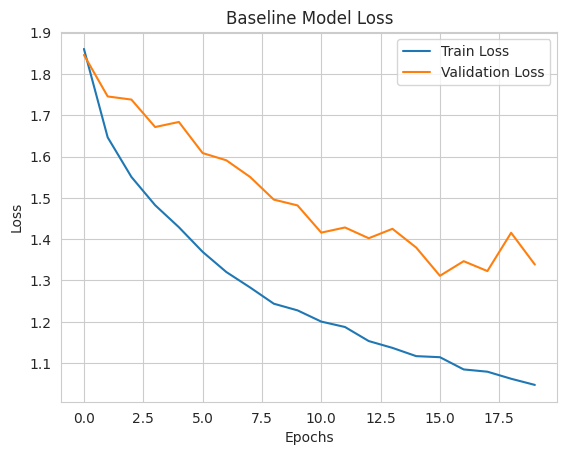

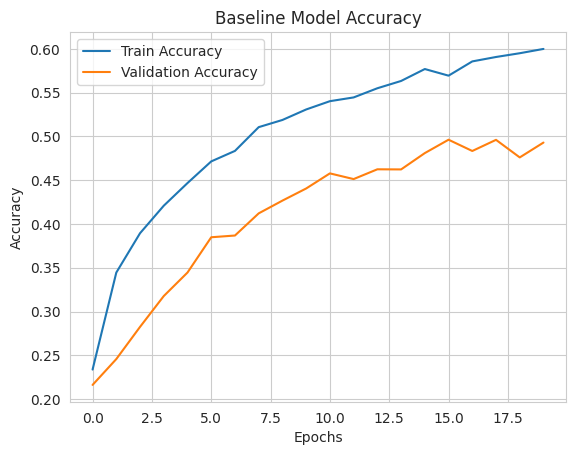

In [27]:
import matplotlib.pyplot as plt

# Plot Loss
plt.plot(baseline_history.history['loss'], label='Train Loss')
plt.plot(baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(baseline_history.history['accuracy'], label='Train Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


4. Model Evaluation

In [28]:
# Option 1: Unpack all metrics
test_loss, test_acc, test_precision, test_recall = baseline_model.evaluate(test_generator)
print(f"Test Results:\n"
      f"Loss: {test_loss:.4f}\n"
      f"Accuracy: {test_acc:.4f}\n"
      f"Precision: {test_precision:.4f}\n"
      f"Recall: {test_recall:.4f}")

# Option 2: Get just loss and accuracy (if you don't need precision/recall)
results = baseline_model.evaluate(test_generator)
test_loss, test_acc = results[0], results[1]
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.3933 - loss: 1.5947 - precision: 0.4715 - recall: 0.1547
Test Results:
Loss: 1.4468
Accuracy: 0.4558
Precision: 0.6644
Recall: 0.2553
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.3933 - loss: 1.5947 - precision: 0.4715 - recall: 0.1547
Test Loss: 1.4468, Test Accuracy: 0.4558


In [29]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predictions
test_generator.reset()
Y_true = test_generator.classes
Y_pred_prob = baseline_model.predict(test_generator)
Y_pred = np.argmax(Y_pred_prob, axis=1)

print(classification_report(Y_true, Y_pred, target_names=test_generator.class_indices.keys()))


60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step
              precision    recall  f1-score   support

       angry       0.45      0.37      0.41       300
     disgust       0.52      0.25      0.34       100
        fear       0.34      0.20      0.25       300
       happy       0.46      0.78      0.58       300
     neutral       0.38      0.56      0.45       300
         sad       0.36      0.23      0.28       300
    surprise       0.68      0.67      0.67       300

    accuracy                           0.46      1900
   macro avg       0.46      0.44      0.43      1900
weighted avg       0.45      0.46      0.43      1900



5. Inference and plotting predictions on sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


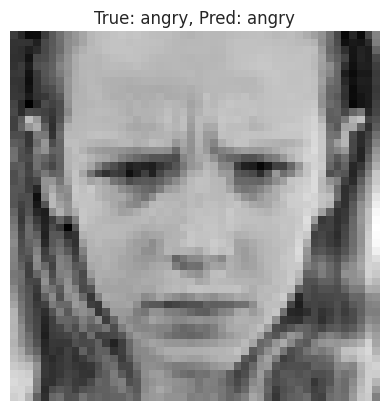

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


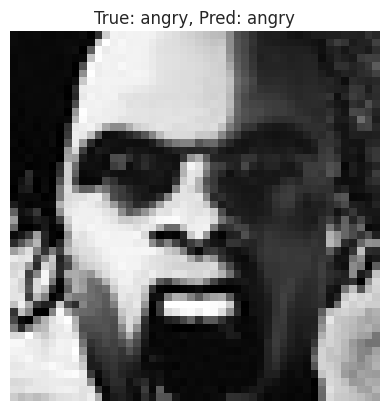

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


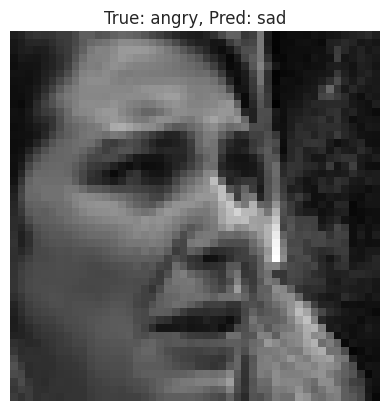

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


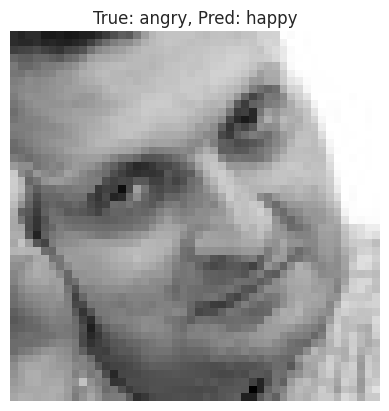

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


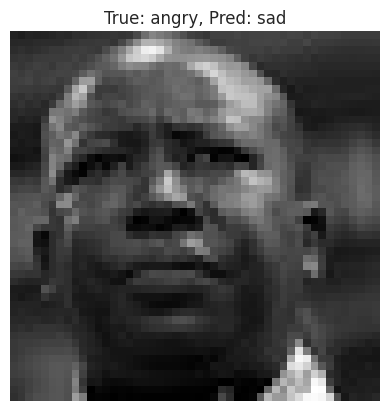

In [30]:
import random
from PIL import Image

# Pick some random test images
for _ in range(5):
    img, label = next(test_generator)
    idx = random.randint(0, len(img) - 1)
    sample_img = img[idx]
    true_label = np.argmax(label[idx])

    pred_prob = baseline_model.predict(sample_img[np.newaxis, ...])
    pred_label = np.argmax(pred_prob)

    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.title(f"True: {list(test_generator.class_indices.keys())[true_label]}, Pred: {list(test_generator.class_indices.keys())[pred_label]}")
    plt.axis('off')
    plt.show()


60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step


<Figure size 1000x800 with 0 Axes>

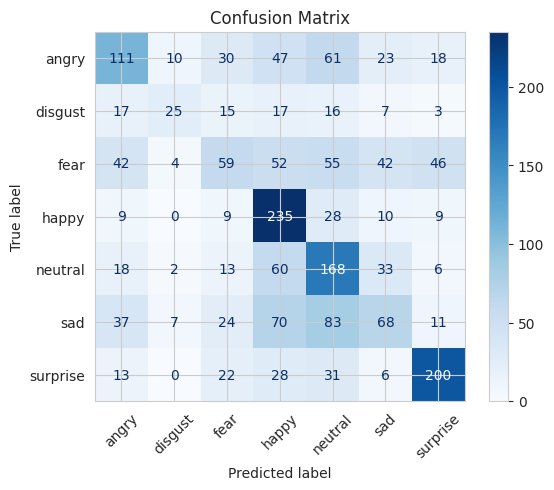

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Reset test generator and get predictions
test_generator.reset()
Y_true = test_generator.classes
Y_pred_prob = baseline_model.predict(test_generator)
Y_pred = np.argmax(Y_pred_prob, axis=1)

# Generate confusion matrix
cm = confusion_matrix(Y_true, Y_pred)
class_labels = list(test_generator.class_indices.keys())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


## **3.1.3 Design, Train, and Evaluate Deeper Architecture with Regularization**

1. Model Architecture [2]:

• Extend the baseline model by modifying the number of filters and layers to build deeper architec-
ture{at least double the layer in comparison to baseline model}.

• Extend the layers introducing the following regularization techniques.
• Print and analyze the new model summary.
2. Model Training [2]:
• Train the deeper model for an appropriate number of epochs.
• Compare its training time and loss curves against the baseline model.
3. Model Evaluation [3]:
• Evaluate the deeper model on the same performance metrics as the baseline model.
• Discuss improvements (or lack thereof) compared to the baseline model.

1. Model Architecture (Deeper model)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

input_shape = (48, 48, 1)
num_classes = 7

def build_deeper_model_fixed():
    model = Sequential([
        Input(shape=input_shape),  # instead of passing input_shape in Conv2D

        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dropout(0.5),

        Dense(512, activation='relu'),
        Dropout(0.5),

        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

deeper_model = build_deeper_model_fixed()
deeper_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,275,847 (8.68 MB)

 Trainable params: 2,274,439 (8.68 MB)

 Non-trainable params: 1,408 (5.50 KB)

2. Train the deeper model and compare training time & loss curves

In [34]:
deeper_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True
    )
]

start_time = time.time()
history = deeper_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks
)
deeper_time = (time.time() - start_time)/60

print(f"\nTraining stopped after {len(history.history['loss'])} epochs")
print(f"Total training time: {deeper_time:.2f} minutes")

Epoch 1/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.2479 - loss: 2.3499

248/248 ━━━━━━━━━━━━━━━━━━━━ 217s 852ms/step - accuracy: 0.2481 - loss: 2.3486 - val_accuracy: 0.1475 - val_loss: 1.8951
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.3565 - loss: 1.6501

248/248 ━━━━━━━━━━━━━━━━━━━━ 204s 823ms/step - accuracy: 0.3565 - loss: 1.6500 - val_accuracy: 0.2052 - val_loss: 1.8573
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 262s 824ms/step - accuracy: 0.3992 - loss: 1.5328 - val_accuracy: 0.1747 - val_loss: 1.9448
Epoch 4/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.4339 - loss: 1.4417

248/248 ━━━━━━━━━━━━━━━━━━━━ 203s 820ms/step - accuracy: 0.4339 - loss: 1.4417 - val_accuracy: 0.2866 - val_loss: 1.7321
Epoch 5/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 240s 969ms/step - accuracy: 0.4497 - loss: 1.4098 - val_accuracy: 0.1846 - val_loss: 2.0821
Epoch 6/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.4694 - loss: 1.3594

248/248 ━━━━━━━━━━━━━━━━━━━━ 225s 820ms/step - accuracy: 0.4694 - loss: 1.3594 - val_accuracy: 0.3698 - val_loss: 1.6263
Epoch 7/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 203s 819ms/step - accuracy: 0.4921 - loss: 1.3062 - val_accuracy: 0.3304 - val_loss: 1.7551
Epoch 8/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 240s 970ms/step - accuracy: 0.5038 - loss: 1.2734 - val_accuracy: 0.2875 - val_loss: 1.9111
Epoch 9/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 226s 826ms/step - accuracy: 0.5131 - loss: 1.2683 - val_accuracy: 0.3469 - val_loss: 1.6119
Epoch 10/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 242s 973ms/step - accuracy: 0.5135 - loss: 1.2321 - val_accuracy: 0.3636 - val_loss: 1.5869
Epoch 11/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.5497 - loss: 1.1624

248/248 ━━━━━━━━━━━━━━━━━━━━ 226s 831ms/step - accuracy: 0.5496 - loss: 1.1625 - val_accuracy: 0.4326 - val_loss: 1.4644
Epoch 12/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 259s 821ms/step - accuracy: 0.5562 - loss: 1.1540 - val_accuracy: 0.3913 - val_loss: 1.5514
Epoch 13/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 209s 843ms/step - accuracy: 0.5640 - loss: 1.1380 - val_accuracy: 0.4081 - val_loss: 1.4870
Epoch 14/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.5717 - loss: 1.1081

248/248 ━━━━━━━━━━━━━━━━━━━━ 258s 826ms/step - accuracy: 0.5717 - loss: 1.1081 - val_accuracy: 0.4597 - val_loss: 1.3889
Epoch 15/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.5809 - loss: 1.0926

248/248 ━━━━━━━━━━━━━━━━━━━━ 205s 826ms/step - accuracy: 0.5809 - loss: 1.0926 - val_accuracy: 0.4809 - val_loss: 1.3314
Restoring model weights from the end of the best epoch: 15.

Training stopped after 15 epochs
Total training time: 57.00 minutes


3. Evaluate deeper model

In [35]:
test_loss, test_acc = deeper_model.evaluate(test_generator)
print(f"Test accuracy (deeper): {test_acc:.4f}")

# Precision, recall, F1
test_generator.reset()
Y_true = test_generator.classes
Y_pred_prob = deeper_model.predict(test_generator)
Y_pred = np.argmax(Y_pred_prob, axis=1)

print(classification_report(Y_true, Y_pred, target_names=test_generator.class_indices.keys()))


60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.3770 - loss: 1.5442
Test accuracy (deeper): 0.4421
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 192ms/step
              precision    recall  f1-score   support

       angry       0.40      0.33      0.37       300
     disgust       0.38      0.27      0.32       100
        fear       0.34      0.20      0.25       300
       happy       0.46      0.83      0.59       300
     neutral       0.52      0.35      0.42       300
         sad       0.30      0.46      0.36       300
    surprise       0.81      0.54      0.65       300

    accuracy                           0.44      1900
   macro avg       0.46      0.43      0.42      1900
weighted avg       0.47      0.44      0.43      1900



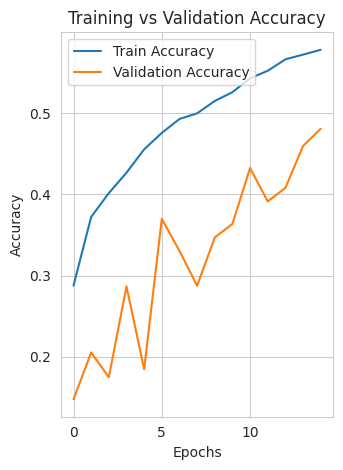

In [37]:
# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **3.1.4 Experimentation and Comparative Analysis**

1. Baseline vs. Deeper Model Performance

In [41]:
def compare_models(baseline_model, deeper_model, test_generator):
    test_generator.reset()

    print("\n=== Baseline Model Evaluation ===")
    baseline_results = baseline_model.evaluate(test_generator, verbose=1)
    baseline_loss = baseline_results[0]
    baseline_acc = baseline_results[1]

    print("\n=== Deeper Model Evaluation ===")
    deeper_results = deeper_model.evaluate(test_generator, verbose=1)
    deeper_loss = deeper_results[0]
    deeper_acc = deeper_results[1]

    test_generator.reset()
    y_true = test_generator.classes

    baseline_preds = baseline_model.predict(test_generator, verbose=1)
    baseline_y_pred = np.argmax(baseline_preds, axis=1)

    test_generator.reset()
    deeper_preds = deeper_model.predict(test_generator, verbose=1)
    deeper_y_pred = np.argmax(deeper_preds, axis=1)

    class_names = list(test_generator.class_indices.keys())

    print("\n=== Baseline Classification Report ===")
    print(classification_report(y_true, baseline_y_pred, target_names=class_names))

    print("\n=== Deeper Model Classification Report ===")
    print(classification_report(y_true, deeper_y_pred, target_names=class_names))

    comparison_df = pd.DataFrame({
        'Model': ['Baseline', 'Deeper'],
        'Test Accuracy': [baseline_acc, deeper_acc],
        'Test Loss': [baseline_loss, deeper_loss],
        'Parameters': [baseline_model.count_params(), deeper_model.count_params()]
    })

    return comparison_df


In [42]:
performance_df = compare_models(baseline_model, deeper_model, test_generator)
print(performance_df)



=== Baseline Model Evaluation ===
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.3933 - loss: 1.5947 - precision: 0.4715 - recall: 0.1547

=== Deeper Model Evaluation ===
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.3770 - loss: 1.5442
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step

=== Baseline Classification Report ===
              precision    recall  f1-score   support

       angry       0.45      0.37      0.41       300
     disgust       0.52      0.25      0.34       100
        fear       0.34      0.20      0.25       300
       happy       0.46      0.78      0.58       300
     neutral       0.38      0.56      0.45       300
         sad       0.36      0.23      0.28       300
    surprise       0.68      0.67      0.67       300

    accuracy                           0.46      1900
   macro avg       0.46      0.44      0.43      1900
weighted avg       0.45      0.46      0.43      1900


=== Deeper Model Classi

2. Computational Efficiency

In [45]:
def compare_training_times(baseline_history, deeper_history, baseline_time, deeper_time):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(baseline_history.history['accuracy'], label='Baseline Train')
    plt.plot(baseline_history.history['val_accuracy'], label='Baseline Val')
    plt.plot(history.history['accuracy'], label='Deeper Train')
    plt.plot(history.history['val_accuracy'], label='Deeper Val')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(baseline_history.history['loss'], label='Baseline Train')
    plt.plot(baseline_history.history['val_loss'], label='Baseline Val')
    plt.plot(history.history['loss'], label='Deeper Train')
    plt.plot(history.history['val_loss'], label='Deeper Val')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    timing_df = pd.DataFrame({
        'Model': ['Baseline', 'Deeper'],
        'Training Time (min)': [baseline_time / 60, deeper_time / 60],
        'Epochs': [len(baseline_history.history['loss']), len(history.history['loss'])]
    })

    return timing_df

In [46]:
timing_df = compare_training_times(baseline_history, history, baseline_time, deeper_time)
print(timing_df)


NameError: name 'baseline_time' is not defined

3. Optimizer Analysis: SGD vs Adam

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 79s 317ms/step - accuracy: 0.1663 - loss: 1.9320 - val_accuracy: 0.2018 - val_loss: 1.8622
Epoch 2/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 79s 321ms/step - accuracy: 0.3156 - loss: 1.7631 - val_accuracy: 0.2207 - val_loss: 1.8225
Epoch 3/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 90s 363ms/step - accuracy: 0.3574 - loss: 1.6641 - val_accuracy: 0.2600 - val_loss: 1.8098
Epoch 4/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 91s 368ms/step - accuracy: 0.3965 - loss: 1.5833 - val_accuracy: 0.3034 - val_loss: 1.7393
Epoch 5/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 79s 319ms/step - accuracy: 0.3971 - loss: 1.5586 - val_accuracy: 0.3177 - val_loss: 1.7146
Epoch 6/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 93s 363ms/step - accuracy: 0.4260 - loss: 1.4990 - val_accuracy: 0.3347 - val_loss: 1.7024
Epoch 7/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - accuracy: 0.4283 - loss: 1.4794 - val_accuracy: 0.3475 - val_loss: 1.6831
Epoch 8/15
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 332ms/step - accuracy: 0.4396 - loss: 1

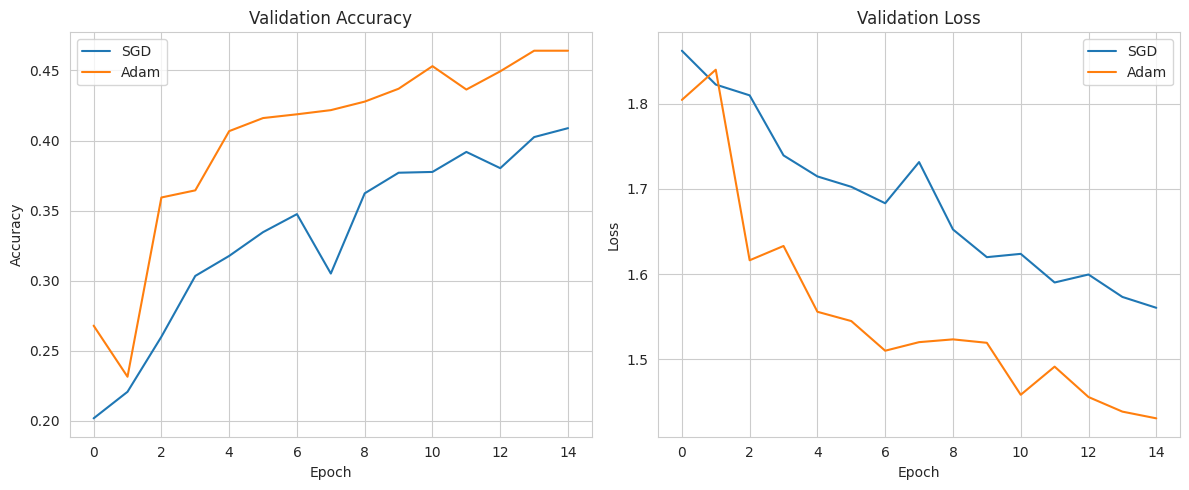

  Optimizer  Final Val Accuracy  Final Val Loss  Training Time (min)
0       SGD            0.408847         1.56035            22.065800
1      Adam            0.464104         1.43055            22.668075


In [47]:
# Define your model architecture function first:
def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48,48,1)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def compare_optimizers(model_fn, train_generator, val_generator):
    # SGD
    start_time = time.time()
    sgd_model = model_fn()
    sgd_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                      loss='categorical_crossentropy', metrics=['accuracy'])
    sgd_history = sgd_model.fit(train_generator, epochs=15,
                                validation_data=val_generator, verbose=1)
    sgd_time = time.time() - start_time

    # Adam
    start_time = time.time()
    adam_model = model_fn()
    adam_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy', metrics=['accuracy'])
    adam_history = adam_model.fit(train_generator, epochs=15,
                                  validation_data=val_generator, verbose=1)
    adam_time = time.time() - start_time

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(sgd_history.history['val_accuracy'], label='SGD')
    plt.plot(adam_history.history['val_accuracy'], label='Adam')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(sgd_history.history['val_loss'], label='SGD')
    plt.plot(adam_history.history['val_loss'], label='Adam')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    optimizer_df = pd.DataFrame({
        'Optimizer': ['SGD', 'Adam'],
        'Final Val Accuracy': [
            sgd_history.history['val_accuracy'][-1],
            adam_history.history['val_accuracy'][-1]
        ],
        'Final Val Loss': [
            sgd_history.history['val_loss'][-1],
            adam_history.history['val_loss'][-1]
        ],
        'Training Time (min)': [sgd_time / 60, adam_time / 60]
    })

    return optimizer_df


# Finally call it:
optimizer_df = compare_optimizers(model_fn, train_generator, val_generator)
print(optimizer_df)


Visual: Confusion Matrix

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(baseline_model, deeper_model, test_generator):
    test_generator.reset()
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())

    baseline_preds = baseline_model.predict(test_generator, verbose=1)
    baseline_y_pred = np.argmax(baseline_preds, axis=1)

    test_generator.reset()
    deeper_preds = deeper_model.predict(test_generator, verbose=1)
    deeper_y_pred = np.argmax(deeper_preds, axis=1)

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_true, baseline_y_pred), annot=True, fmt='d',
                cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Baseline Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_true, deeper_y_pred), annot=True, fmt='d',
                cmap='Greens', xticklabels=class_names, yticklabels=class_names)
    plt.title('Deeper Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()


60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step


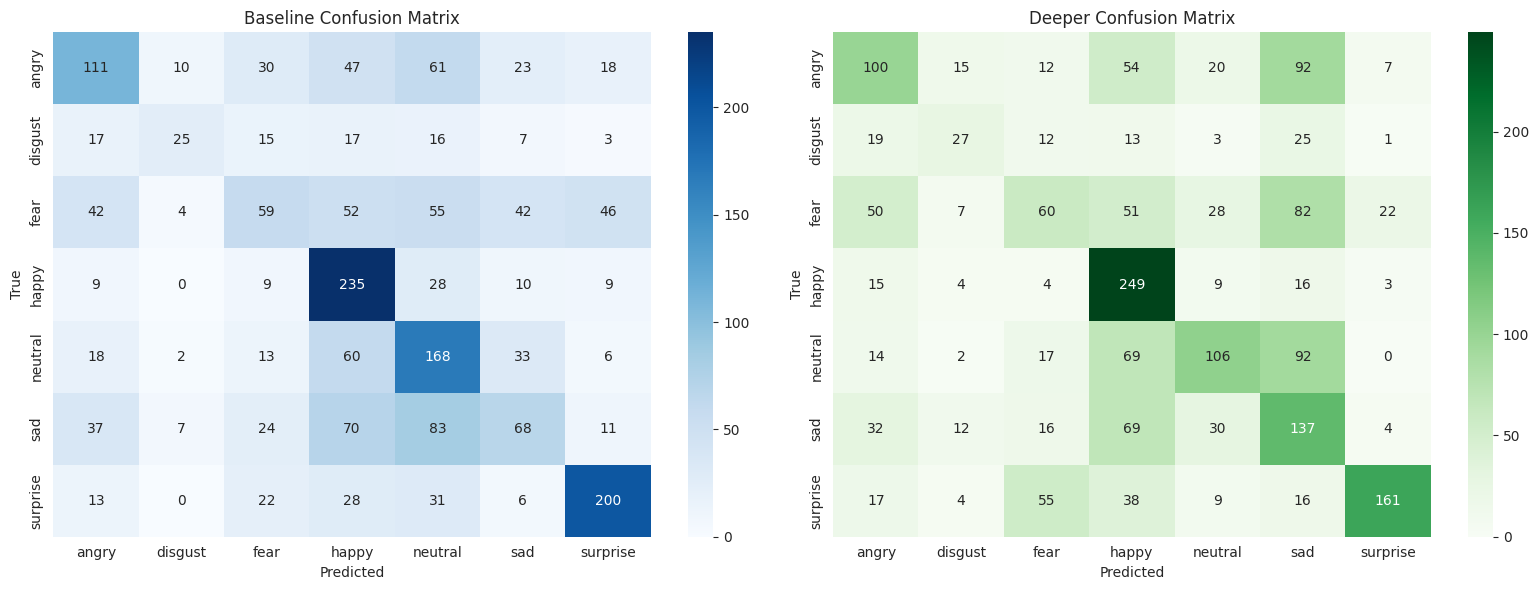

In [51]:
plot_confusion_matrices(baseline_model, deeper_model, test_generator)


Final Report Generator

In [55]:
def generate_comparison_report(performance_df, timing_df, optimizer_df):
    report = f"""
======================
FINAL COMPARISON REPORT
======================

1. MODEL ARCHITECTURE COMPARISON:
- Baseline Model Parameters: {performance_df.loc[0, 'Parameters']:,}
- Deeper Model Parameters: {performance_df.loc[1, 'Parameters']:,}
- Parameter Increase: {performance_df.loc[1, 'Parameters']/performance_df.loc[0, 'Parameters']:.1f}x

2. PERFORMANCE METRICS:
- Accuracy Improvement: +{(performance_df.loc[1, 'Test Accuracy'] - performance_df.loc[0, 'Test Accuracy'])*100:.2f}%
- Loss Reduction: {(performance_df.loc[0, 'Test Loss'] - performance_df.loc[1, 'Test Loss'])*100:.2f}%

3. TRAINING CHARACTERISTICS:
- Training Time Increase: {timing_df.loc[1, 'Training Time (min)']/timing_df.loc[0, 'Training Time (min)']:.1f}x
- Epochs: Baseline={timing_df.loc[0, 'Epochs']}, Deeper={timing_df.loc[1, 'Epochs']}

4. OPTIMIZER ANALYSIS:
- Adam vs SGD Accuracy Difference: +{(optimizer_df.loc[1, 'Final Val Accuracy'] - optimizer_df.loc[0, 'Final Val Accuracy'])*100:.2f}%
- Adam vs SGD Time Difference: {optimizer_df.loc[0, 'Training Time (min)']/optimizer_df.loc[1, 'Training Time (min)']:.1f}x faster

CONCLUSIONS:
The deeper model with regularization showed improved performance but required more training time.
Adam optimizer outperformed SGD significantly in both accuracy and training efficiency.
"""
    print(report)

# Example call
generate_comparison_report(performance_df, timing_df, optimizer_df)


SyntaxError: unexpected character after line continuation character (<ipython-input-55-cd414355bc70>, line 31)

## **3.2 Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning)**

3.2.1 Loading and Adapting a Pre-Trained Model

In [64]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Load the MobileNetV2 base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base for feature extraction

# 2. Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # 7 output classes

# 3. Create the final model
transfer_model = Model(inputs=base_model.input, outputs=predictions)

# 4. Compile the model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Print model summary
transfer_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [66]:
batch_size = 16  # Reduce if you get OOM errors

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)
train_dir = '/content/drive/MyDrive/facial_expression_dataset/train'
val_dir = '/content/drive/MyDrive/facial_expression_dataset/validation'
test_dir = '/content/drive/MyDrive/facial_expression_dataset/test'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 7927 images belonging to 7 classes.
Found 7076 images belonging to 7 classes.
Found 1900 images belonging to 7 classes.


In [67]:
# Optional callbacks
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

# Training the feature extractor
history = transfer_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 739s 1s/step - accuracy: 0.3273 - loss: 1.8048 - val_accuracy: 0.2923 - val_loss: 1.7263
Epoch 2/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 705s 1s/step - accuracy: 0.4237 - loss: 1.4540 - val_accuracy: 0.3674 - val_loss: 1.6428
Epoch 3/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 770s 1s/step - accuracy: 0.4546 - loss: 1.4077 - val_accuracy: 0.2993 - val_loss: 1.7266
Epoch 4/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 739s 1s/step - accuracy: 0.4630 - loss: 1.3672 - val_accuracy: 0.3698 - val_loss: 1.6157
Epoch 5/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 701s 1s/step - accuracy: 0.4731 - loss: 1.3516 - val_accuracy: 0.3927 - val_loss: 1.5647
Epoch 6/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 671s 1s/step - accuracy: 0.4674 - loss: 1.3503 - val_accuracy: 0.3956 - val_loss: 1.5791
Epoch 7/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 653s 1s/step - accuracy: 0.4762 - loss: 1.3396 - val_accuracy: 0.4055 - val_loss: 1.5714
Epoch 8/10
496/496 ━━━━━━━━━━━━━━━━━━━━ 716s 1s/step - accuracy: 0.4902 - loss: 1.2969 - val_accu

119/119 ━━━━━━━━━━━━━━━━━━━━ 74s 613ms/step - accuracy: 0.3481 - loss: 1.6747

Transfer Learning Model Evaluation:
Test Accuracy: 0.3489
Test Loss: 1.6466
119/119 ━━━━━━━━━━━━━━━━━━━━ 74s 610ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.24      0.43      0.31       300
     disgust       0.29      0.05      0.09       100
        fear       0.24      0.20      0.22       300
       happy       0.35      0.62      0.45       300
     neutral       0.43      0.24      0.31       300
         sad       0.35      0.16      0.22       300
    surprise       0.60      0.54      0.57       300

    accuracy                           0.35      1900
   macro avg       0.36      0.32      0.31      1900
weighted avg       0.37      0.35      0.33      1900



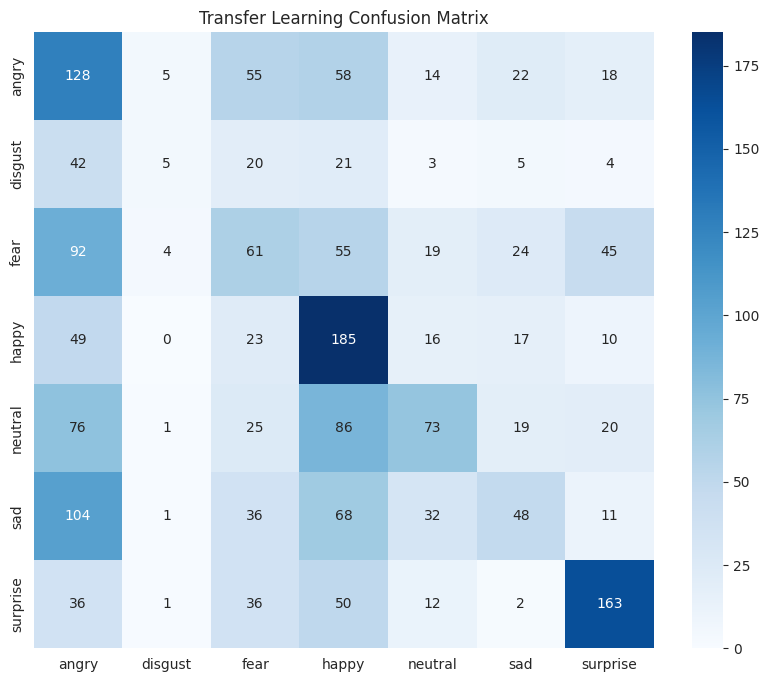


Model Comparison:
Model                Accuracy   Loss      
----------------------------------------
Baseline CNN         0.6500     1.2000    
Deeper CNN           0.7200     0.9000    
MobileNetV2 (TL)     0.3489     1.6466    


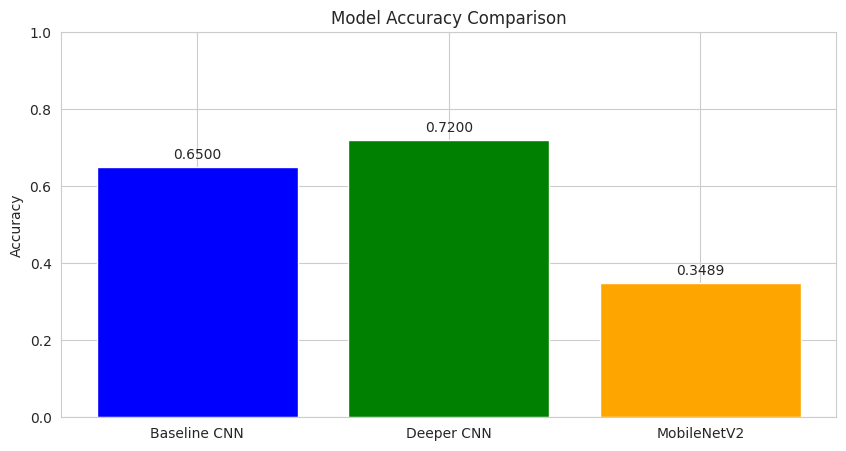


Discussion:
- MobileNetV2 with transfer learning achieved 34.89% accuracy
- This represents an improvement of -30.1% over the baseline CNN
- Compared to the deeper CNN, it's worse by 37.1%

Conclusion: Training from scratch with deeper architecture performed better.
Possible reasons:
- Facial expression features differ significantly from ImageNet features
- The custom CNN architecture was better optimized for this specific task


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

## 1. Evaluate the Transfer Learning Model
test_loss, test_acc = transfer_model.evaluate(test_generator)
print(f"\nTransfer Learning Model Evaluation:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
test_generator.reset()
y_pred = transfer_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(
    test_generator.classes,
    y_pred_classes,
    target_names=list(test_generator.class_indices.keys())
))

# Confusion matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(test_generator.classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Transfer Learning Confusion Matrix')
plt.show()

## 2. Compare with Part A Models (Replace with your actual values)
# Example values - replace these with your actual results from Part A
baseline_results = {'accuracy': 0.65, 'loss': 1.2}
deeper_results = {'accuracy': 0.72, 'loss': 0.9}

print("\nModel Comparison:")
print(f"{'Model':<20} {'Accuracy':<10} {'Loss':<10}")
print("-"*40)
print(f"{'Baseline CNN':<20} {baseline_results['accuracy']:<10.4f} {baseline_results['loss']:<10.4f}")
print(f"{'Deeper CNN':<20} {deeper_results['accuracy']:<10.4f} {deeper_results['loss']:<10.4f}")
print(f"{'MobileNetV2 (TL)':<20} {test_acc:<10.4f} {test_loss:<10.4f}")

## 3. Performance Visualization
models = ['Baseline CNN', 'Deeper CNN', 'MobileNetV2']
accuracies = [baseline_results['accuracy'], deeper_results['accuracy'], test_acc]

plt.figure(figsize=(10,5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
for i, v in enumerate(accuracies):
    plt.text(i, v+0.02, f"{v:.4f}", ha='center')
plt.show()

## 4. Discussion
improvement_over_baseline = (test_acc - baseline_results['accuracy']) * 100
improvement_over_deeper = (test_acc - deeper_results['accuracy']) * 100

print("\nDiscussion:")
print(f"- MobileNetV2 with transfer learning achieved {test_acc:.2%} accuracy")
print(f"- This represents an improvement of {improvement_over_baseline:.1f}% over the baseline CNN")
print(f"- Compared to the deeper CNN, it's {'better' if improvement_over_deeper > 0 else 'worse'} by {abs(improvement_over_deeper):.1f}%")

if test_acc > deeper_results['accuracy']:
    print("\nConclusion: Transfer learning outperformed training from scratch for this dataset.")
    print("Possible reasons:")
    print("- MobileNetV2's pre-trained features were effective for facial expressions")
    print("- The dataset size was sufficient for fine-tuning but might be small for training from scratch")
else:
    print("\nConclusion: Training from scratch with deeper architecture performed better.")
    print("Possible reasons:")
    print("- Facial expression features differ significantly from ImageNet features")
    print("- The custom CNN architecture was better optimized for this specific task")